In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# file directory monthly data:
sdir = '/projects/NS9873K/DATA/SFE/cds_seasonal_forecast/monthly/monthly_mean'

In [3]:
# input:
YEARS = range(1993,2023)
MODEL = 'ecmwf'
MV = '5'
VAR = '2m_temperature'
LON = [5,12]
LAT = [62,58]
# load forecasts for target month 2 (February) with a lead time of 1 month:
lead_mo = 1
trgt_mth = 2

In [4]:
# derive initialization month from combination of target month and lead time:
i_mo = np.mod(trgt_mth - lead_mo - 1,12) + 1
# derive month before initialization from the same combination: 
p_mo = np.mod(trgt_mth - lead_mo - 2,12) + 1
# determine whether a year needs to be subtracted for initialization and/or previous month:
if i_mo > trgt_mth:
    suby = 1
else:
    suby = 0
if p_mo > trgt_mth:
    psuby = 1
else:
    psuby = 0

print('target month: {0:0>2d}'.format(trgt_mth))
print('initialization month: {0:0>2d}'.format(i_mo))
print('previous month: {0:0>2d}'.format(p_mo))

target month: 02
initialization month: 01
previous month: 12


In [5]:
flist = ['{0:s}/{1:s}/{2:s}/{2:s}_{1:s}_{3:s}_{4:d}_{5:0>2d}.nc'.format(sdir,MODEL,VAR,MV,yy,i_mo) for yy in YEARS]
da_merge = []
for ii,fl in enumerate(flist):
    
    with xr.open_dataarray(fl) as da:
        # select box and relevant month:
        da_subs = da.sel(latitude=slice(*LAT),longitude=slice(*LON),time=da.time.dt.month.isin(trgt_mth))
    
    # cosine weighting for spatial average:
    if ii == 0:
        wgts = np.cos(da_subs.latitude/180*np.pi)
        wgts.name = "weights"
    da_spat_av = da_subs.weighted(wgts).mean(('latitude','longitude'))

    da_merge.append(da_spat_av)

DA = xr.concat(da_merge,dim='time')

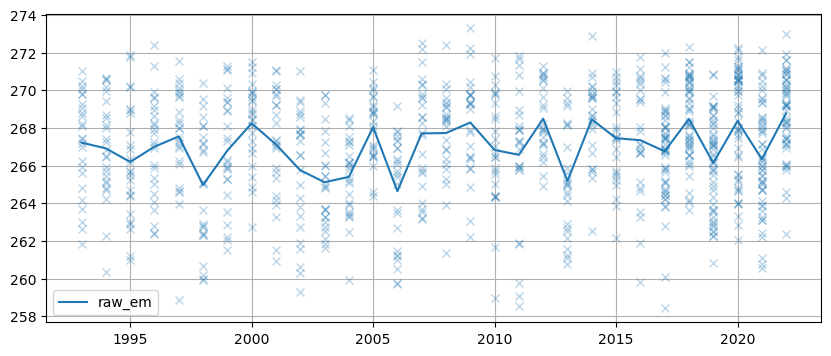

In [6]:
f,ax = plt.subplots(figsize=(10,4))
ax.plot(DA.time.dt.year,DA.values,'C0',alpha=.3,ls='None',marker='x')
ax.plot(DA.time.dt.year,DA.mean('number'),'C0',alpha=1,label='raw_em')
ax.grid()
ax.legend()